## Import required packages

In [ ]:
import requests, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collecting

In [ ]:
# base url for all FPL API endpoints
base_url = 'https://fantasy.premierleague.com/api/'

# get data from bootstrap endpoint
data = requests.get(base_url+'bootstrap-static/').json()

# Data cleaning & Preprocessing

In [ ]:
# getting data for teams
teams = pd.json_normalize(data['teams'])
required_columns_teams = ['id', 'code', 'name', 'short_name', 'strength_overall_home', 'strength_overall_away']
teams = teams[required_columns_teams]

In [ ]:
teams.head()

,id,code,name,short_name,strength_overall_home,strength_overall_away
0,1,3,Arsenal,ARS,1245,1285
1,2,7,Aston Villa,AVL,1070,1100
2,3,91,Bournemouth,BOU,1035,1095
3,4,94,Brentford,BRE,1115,1180
4,5,36,Brighton,BHA,1170,1175


In [ ]:
# getting data for player position
players_position = pd.json_normalize(data['element_types'])
required_columns_players_position = ['id', 'singular_name', 'singular_name_short']
players_position = players_position.loc[:, required_columns_players_position]

In [ ]:
players_position

,id,singular_name,singular_name_short
0,1,Goalkeeper,GKP
1,2,Defender,DEF
2,3,Midfielder,MID
3,4,Forward,FWD


In [ ]:
# getting data for the players
players = pd.json_normalize(data['elements'])
required_columns_players = ['first_name','second_name', 'team', 'element_type','now_cost', 'total_points', 'minutes',
                            'form',  'value_season', 'points_per_game', 'value_form', 'news',
                            'goals_scored', 'assists', 'dreamteam_count','clean_sheets',
                            'goals_conceded', 'own_goals','penalties_saved', 'penalties_missed',
                            'yellow_cards', 'red_cards', 'saves', 'bonus',
                            'influence', 'creativity', 'threat', 'ict_index', 'selected_by_percent']
players = players.loc[:, required_columns_players]

In [ ]:
players.head()

,first_name,second_name,team,element_type,now_cost,total_points,minutes,form,value_season,points_per_game,...,penalties_missed,yellow_cards,red_cards,saves,bonus,influence,creativity,threat,ict_index,selected_by_percent
0,Granit,Xhaka,1,3,49,118,2558,3.0,24.1,3.8,...,0,4,0,0,11,564.4,597.7,426.0,158.9,2.5
1,Mohamed,Elneny,1,3,41,6,111,0.0,1.5,1.2,...,0,0,0,0,0,4.6,5.4,0.0,1.1,0.6
2,Rob,Holding,1,2,42,14,467,1.2,3.3,1.2,...,0,0,0,0,0,97.8,9.7,30.0,13.8,0.2
3,Thomas,Partey,1,3,47,78,2166,1.5,16.6,2.9,...,0,3,0,0,6,485.2,392.7,225.0,110.5,0.4
4,Martin,Ødegaard,1,3,67,178,2653,6.2,26.6,5.7,...,0,4,0,0,25,822.0,987.5,804.0,261.6,29.5


In [ ]:
# renaming columns to proper names in Teams DataFrame
teams.rename(
    columns = {
        'name' : 'Team',
        'id': 'id'
        },
    inplace = True
    )

# Creating Player full name using frist and last names
players['Name'] = players['first_name'].str.cat(players['second_name'], sep = ' ')
players.drop(['first_name', 'second_name'], axis = 1, inplace = True)

# Renaming few columns in Players DataFrame
players.rename(
    columns = {
        'element_type' : 'position_id',
        'team' : 'team_id'
    },
    inplace = True
)

# Renaming few columns in players_position DataFrame
players_position.rename(
    columns = {
        'id': 'id',
        'singular_name': 'Position_Name',
        'singular_name_short': 'Position'
    },
    inplace = True
)

In [ ]:
players = pd.merge(
    left = players,
    right = teams,
    left_on = 'team_id',
    right_on = 'id'
)

players.drop(
    ['id'],
    axis = 1,
    inplace = True
)

players = pd.merge(
    left = players,
    right = players_position,
    left_on = 'position_id',
    right_on = 'id'
)

players.drop(
    ['position_id', 'id'],
    axis = 1,
    inplace = True
)

In [ ]:
# updating the required column list for players
required_columns_players.remove('second_name')
required_columns_players[0] = 'Name'
required_columns_players[1] = 'Team'
required_columns_players[2] = 'Position'
required_columns_players.append('team_id')

players = players.loc[:, required_columns_players]

In [ ]:
# Adding a colummn to identify the player availablity in the players DataFrame
players['IsAvailable'] = np.where(players['news'] != "", False, True)
players.drop('news', axis = 1, inplace = True)

In [ ]:
players_df = (players['minutes'] > players['minutes'].max() * 0.4)
players_df = players.loc[players_df]
players_df.head()

,Name,Team,Position,now_cost,total_points,minutes,form,value_season,points_per_game,value_form,...,red_cards,saves,bonus,influence,creativity,threat,ict_index,selected_by_percent,team_id,IsAvailable
0,Granit Xhaka,Arsenal,MID,49,118,2558,3.0,24.1,3.8,0.6,...,0,0,11,564.4,597.7,426.0,158.9,2.5,1,False
2,Thomas Partey,Arsenal,MID,47,78,2166,1.5,16.6,2.9,0.3,...,0,0,6,485.2,392.7,225.0,110.5,0.4,1,True
3,Martin Ødegaard,Arsenal,MID,67,178,2653,6.2,26.6,5.7,0.9,...,0,0,25,822.0,987.5,804.0,261.6,29.5,1,True
6,Bukayo Saka,Arsenal,MID,85,185,2706,3.8,21.8,5.8,0.4,...,0,0,19,924.6,1008.1,1046.0,298.0,38.8,1,True
7,Gabriel Martinelli Silva,Arsenal,MID,69,189,2601,8.0,27.4,5.9,1.2,...,0,0,18,826.6,813.0,1255.0,289.4,44.5,1,True


In [ ]:
cols = ['points_per_game', 'selected_by_percent', 'value_season',
        'influence', 'creativity', 'threat', 'ict_index']

players_df[cols] = players_df.loc[:, tuple(cols)].astype('float32')

<ipython-input-186-bdfebcc9f860>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_df[cols] = players_df.loc[:, tuple(cols)].astype('float32')


In [ ]:
#Look for outliers
players_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
now_cost,237.0,54.101266,14.578480,38.000000,45.000000,50.000000,56.000000,129.000000
total_points,237.0,84.742616,34.055743,29.000000,62.000000,82.000000,105.000000,227.000000
minutes,237.0,2020.392405,491.829172,1155.000000,1617.000000,2017.000000,2429.000000,2880.000000
value_season,237.0,15.760337,5.186957,5.700000,11.700000,15.100000,19.299999,27.900000
points_per_game,237.0,3.201266,1.025087,1.400000,2.500000,3.100000,3.700000,8.100000
goals_scored,237.0,2.772152,4.115749,0.000000,0.000000,1.000000,4.000000,32.000000
assists,237.0,2.506329,2.745752,0.000000,0.000000,2.000000,4.000000,17.000000
dreamteam_count,237.0,1.202532,1.387411,0.000000,0.000000,1.000000,2.000000,9.000000
clean_sheets,237.0,6.767932,2.865810,0.000000,5.000000,7.000000,9.000000,15.000000
goals_conceded,237.0,30.683544,10.158754,11.000000,23.000000,30.000000,37.000000,62.000000


# Data Analytics & Visualization

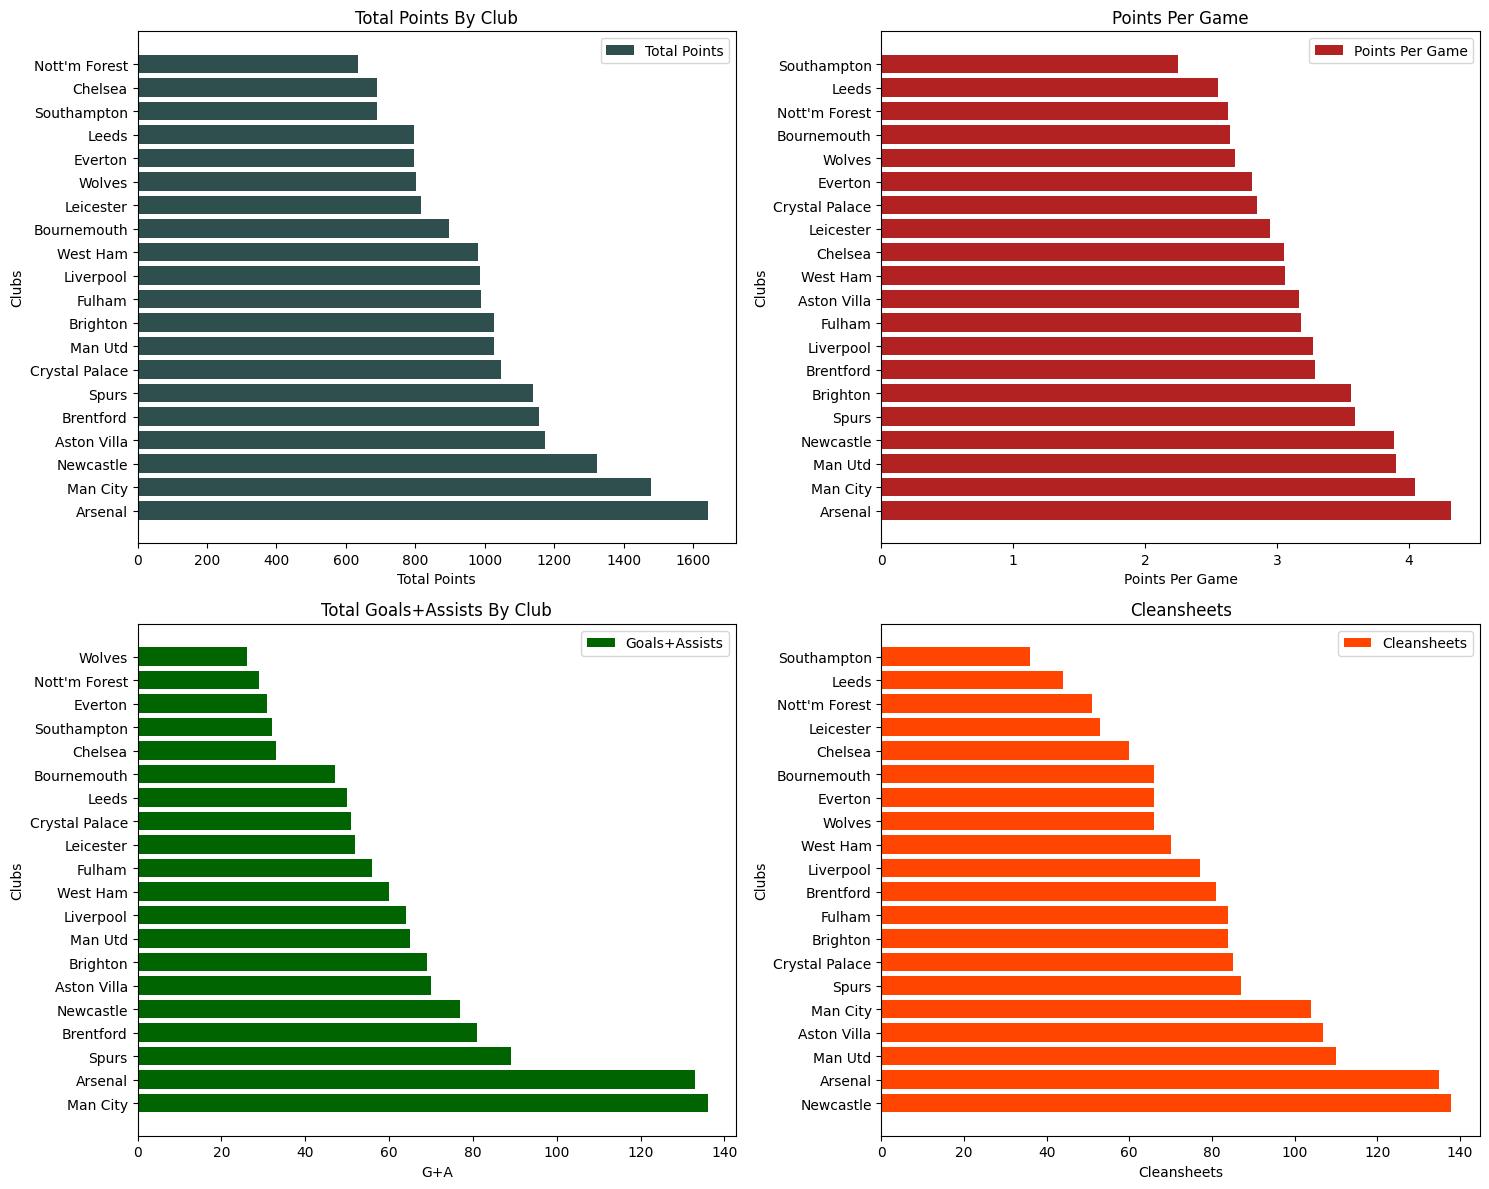

In [ ]:
team_total_points = players_df.groupby('Team')[['total_points']].sum()
team_total_points.sort_values('total_points', ascending = False, inplace = True)

team_points_per_game = players_df.groupby('Team')[['points_per_game']].mean()
team_points_per_game.sort_values('points_per_game', ascending = False, inplace = True)

team_goals_assist = players_df.loc[:, ['Name', 'Team', 'goals_scored', 'assists']]
team_goals_assist['Goals+Assists'] = team_goals_assist['goals_scored'] + team_goals_assist['assists']
team_goals_assist = team_goals_assist.groupby('Team')[['Goals+Assists']].sum()
team_goals_assist.sort_values('Goals+Assists', ascending = False, inplace = True)

teams_cleansheets = players_df.groupby('Team')[['clean_sheets']].sum()
teams_cleansheets.sort_values('clean_sheets', ascending = False, inplace = True)

fg, ax = plt.subplots(2, 2, figsize=(15,12))

(ax1, ax2), (ax3, ax4) = ax

#Plot 1
x1 = team_total_points.index
y1 = team_total_points['total_points']
ax1.barh(x1, y1, label='Total Points', color='#2F4F4F')
ax1.set(title='Total Points By Club', ylabel='Clubs', xlabel='Total Points')
ax1.legend()

#Plot 2
x2 = team_points_per_game.index
y2 = team_points_per_game['points_per_game']
ax2.barh(x2, y2, label='Points Per Game', color='#B22222')
ax2.set(title='Points Per Game', ylabel='Clubs', xlabel='Points Per Game')
ax2.legend()

#Plot 3
x3 = team_goals_assist.index
y3 = team_goals_assist['Goals+Assists']
ax3.barh(x3, y3, label='Goals+Assists', color='#006400')
ax3.set(title='Total Goals+Assists By Club', ylabel='Clubs', xlabel='G+A')
ax3.legend()

#Plot 4
x4 = teams_cleansheets.index
y4 = teams_cleansheets['clean_sheets']
ax4.barh(x4, y4, label='Cleansheets', color='#FF4500')
ax4.set(title='Cleansheets', ylabel='Clubs', xlabel='Cleansheets')
ax4.legend()

plt.tight_layout()

The bar charts provide some useful insights on which teams performing well over the season. A high performing team is most likely to include high performing players by virtue of goal contributions and defensive contributions which are the cornerstone for picking players. These are the teams where will choose our base squad from which will have our long-term and premium players.

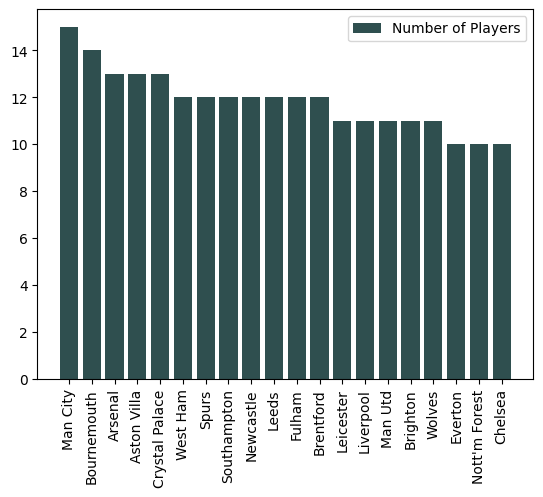

In [ ]:
rotation_df = players_df['Team'].value_counts().to_frame()

#Plot
x = rotation_df.index
y = rotation_df['Team']
plt.bar(x, y, label='Number of Players', color='#2F4F4F')
plt.title='Number of Players With Over 40% of Season Minutes Played'
plt.xlabel='Clubs'
plt.ylabel='Number of Players'
plt.xticks(rotation='vertical')
plt.legend();



To maximize on potential points, it is always good to choose players that are most likely to start and finish the game. The less players used by a club, the better; as this means that the potential for rotation is very low.

Analysis By Position:

Next in our analysis we look at which positions to has the best performing players. This will guide us in structuring our squad and distribution of funds. Similar to investing in stocks, you first choose a market that is performing well and from there you choose specific companies that perform well. This same logic will be applied with positions being the market.

Here we continue with our "players_df" (players with atleast 40% of total season minutes) as these are the only players that will provide any statistical significance. From this dataframe, we will filter and only focus on the players that are above average (50%) in the follwing statistical categories: Total points, Points per game, Bonus, and Value Season. To be fair, the average for Midfielders will be used to filter Midfielders, Defenders for Defenders and so on so that apples are compared with apples. We will refer to this group as "high performing players".

In [ ]:
def get_top_50_pct(data_f, pos_list):
    pos_df = players_df.groupby('Position')
    above_avg_players = list(pos_df.apply(lambda x: x[(x['total_points'] > x['total_points'].quantile(0.5)) &
                                        (x['points_per_game'] > x['points_per_game'].quantile(0.5)) &
                                        (x['value_season'] > x['value_season'].quantile(0.5)) &
                                        (x['bonus'] > x['bonus'].quantile(0.5))]['Name']))
    return above_avg_players

In [ ]:
positions = players_position['Position']
above_ave_players = get_top_50_pct(players_df, positions)

top_df = players_df.set_index('Name').loc[above_ave_players].reset_index()
top_df['Position'].value_counts()

MID    27
DEF    23
FWD     5
GKP     5
Name: Position, dtype: int64

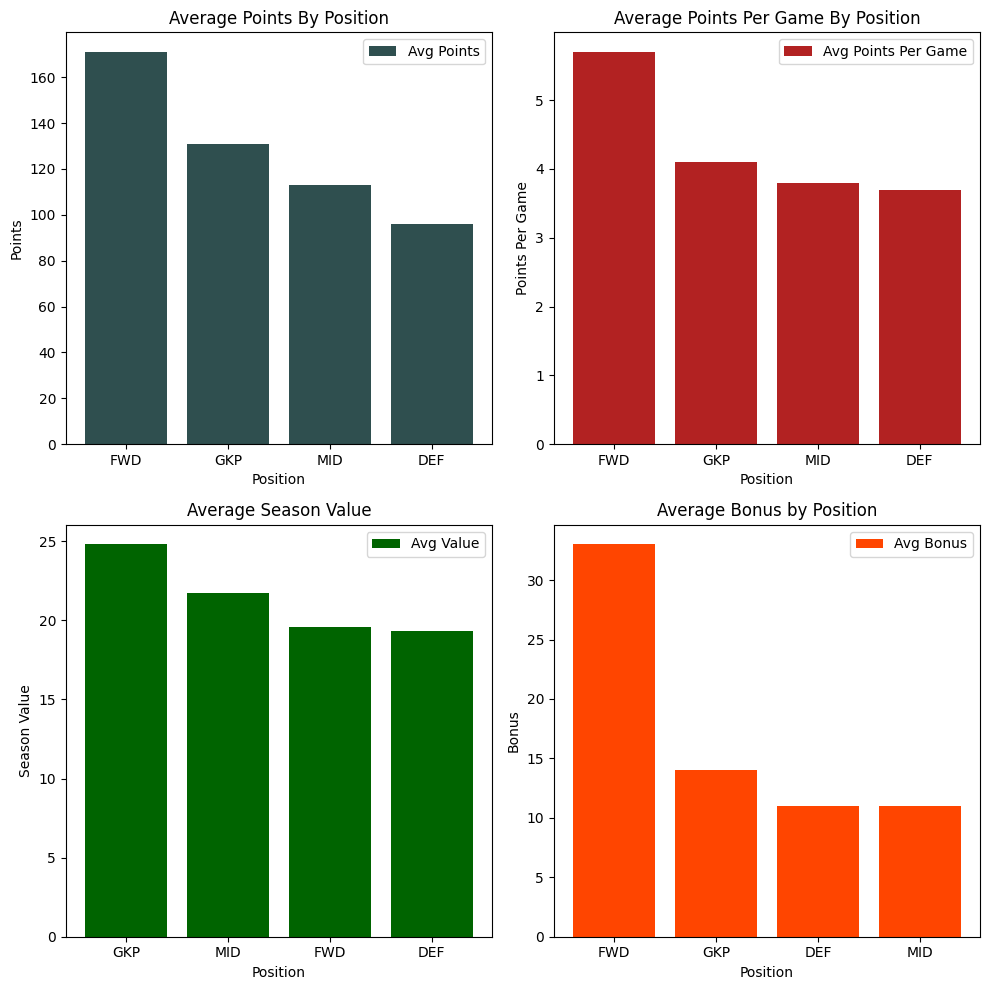

In [ ]:
tp_df = top_df.groupby('Position')[['total_points']].median()
tp_df.sort_values(by='total_points', ascending=False, inplace = True)

ppg_df = top_df.groupby('Position')[['points_per_game']].median()
ppg_df.sort_values(by='points_per_game', ascending=False, inplace = True)

val_df = top_df.groupby('Position')[['value_season']].median()
val_df.sort_values(by='value_season', ascending=False, inplace = True)

bonus_df = top_df.groupby('Position')[['bonus']].median()
bonus_df.sort_values(by='bonus', ascending=False, inplace = True)

fg, ax = plt.subplots(2, 2, figsize=(10,10))

(ax1, ax2), (ax3, ax4) = ax

#Plot 1
x1 = tp_df.index
y1 = tp_df['total_points']
ax1.bar(x1, y1, label='Avg Points', color='#2F4F4F')
ax1.set(title='Average Points By Position', xlabel='Position', ylabel='Points')
ax1.legend()

#Plot 2
x2 = ppg_df.index
y2 = ppg_df['points_per_game']
ax2.bar(x2, y2, label='Avg Points Per Game', color='#B22222')
ax2.set(title='Average Points Per Game By Position', xlabel='Position', ylabel='Points Per Game')
ax2.legend()

#Plot 3
x3 = val_df.index
y3 = val_df['value_season']
ax3.bar(x3, y3, label='Avg Value', color='#006400')
ax3.set(title='Average Season Value', xlabel='Position', ylabel='Season Value')
ax3.legend()

#Plot 4
x4 = bonus_df.index
y4 = bonus_df['bonus']
ax4.bar(x4, y4, label='Avg Bonus', color='#FF4500')
ax4.set(title='Average Bonus by Position', xlabel='Position', ylabel='Bonus')
ax4.legend()

plt.tight_layout()

NOTE: Statistics only apply to *above average players:

When it comes down to points per game, each position managers atleast 4 points per game.
Over the course of a season, goalkeepers and defenders generally provide the best value due to their lower price points.
The FPL bonus points system generally rewards attacking actions more than defensive actions. This gives an advantage to forwards, midfielders and attack-minded defenders. On average forwards scored atleast 3 more bonus points than the other positions.

In [ ]:
bins = [0, 60, 80, 100, 120, 140, 160, 180, 200, 500]
labels = ['<60', '60-80', '80-100', '100-120', '120-140', '140-160', '160-180', '180-200', '200+']
top_df['points_range'] = pd.cut(top_df['total_points'], bins=bins, labels=labels)

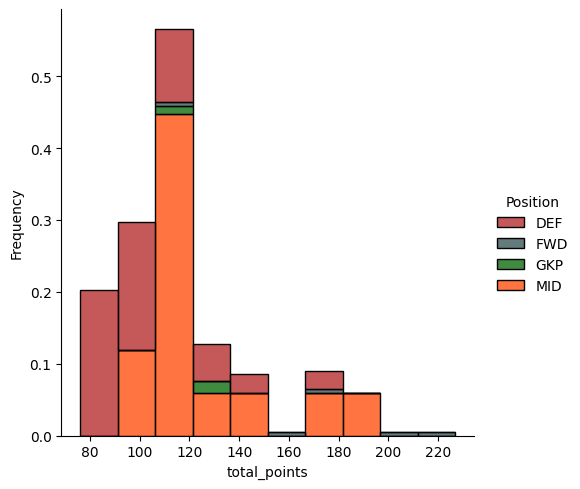

In [ ]:
#Distribution of points by position
cp = sns.color_palette(['#B22222','#2F4F4F','#006400','#FF4500'])
sns.displot(top_df, x='total_points', hue='Position', multiple='stack', stat='frequency', bins=10, palette=cp);

The key takeways from this plot is the heights of the bars. The more times a position's total points is accounted for within a certain range of values, the greater the bar.

1. The positions with the majority of high performing players were in the Midfield and Defense.
2. Midfielder and Defenders also dominate season points. Investing heavily in these positions would have yielded great returns over the season. These positions would have been great for long-term investments.
3. There were only a few high performing Forwards and Goalkeepers to choose from last season. These positions would have been great for short-term investments based on form or fixtures.
4. The outliers in terms of season points totals (> 180 pts) were Forwards, which again shows the great points potential that the Forward have.

In [ ]:
top_df['price'] = top_df['now_cost'] / 10
top_df.drop('now_cost', axis = 'columns', inplace = True)

In [ ]:
top_df.groupby('Position')['price'].min()

Position
DEF    4.3
FWD    5.6
GKP    4.6
MID    4.4
Name: price, dtype: float64

In [ ]:
top_df.groupby('Position')['price'].max()

Position
DEF     7.5
FWD    12.2
GKP     5.4
MID     8.5
Name: price, dtype: float64

In [ ]:
# Define bins and labels
gk_bins = [4.0, 5.0, 6.0, 7.0]
def_bins = [4.0, 5.0, 6.0, 8.0]
mid_bins = [4.0, 6.0, 9.0, 14.0]
for_bins = [4.0, 6.0, 9.0, 14.0]
labels = ['Budget', 'Mid Priced', 'Premium']

# Define discretization function
def categorize_price(grp, bins, labels):
    grp_prices = grp['price']
    grp.loc[:, 'price_range'] = pd.cut(grp_prices, bins, labels=labels, right=False)
    return grp

# Create list of tuples
tup = [(top_df, gk_bins, 'GKP'),
       (top_df, def_bins, 'DEF'),
       (top_df, mid_bins, 'MID'),
       (top_df, for_bins, 'FWD')]

# Apply discretization function to each tuple in the list
grp_lst = [categorize_price(df.groupby('Position').get_group(pos), bins, labels).assign(Position=pos) for df, bins, pos in tup]

top_df = pd.concat(grp_lst)

<ipython-input-198-edff2a00cc21>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grp.loc[:, 'price_range'] = pd.cut(grp_prices, bins, labels=labels, right=False)
<ipython-input-198-edff2a00cc21>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grp.loc[:, 'price_range'] = pd.cut(grp_prices, bins, labels=labels, right=False)
<ipython-input-198-edff2a00cc21>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# So, in simpler terms, this function takes the percentage of a pie chart
# slice and converts it to the corresponding number of players that slice represents.
# For example, if a slice represents 25% of the total players,
# the function will return the number of players that make up 25% of the total, rounded to the nearest whole number.

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:}'.format(v=val)
    return my_autopct

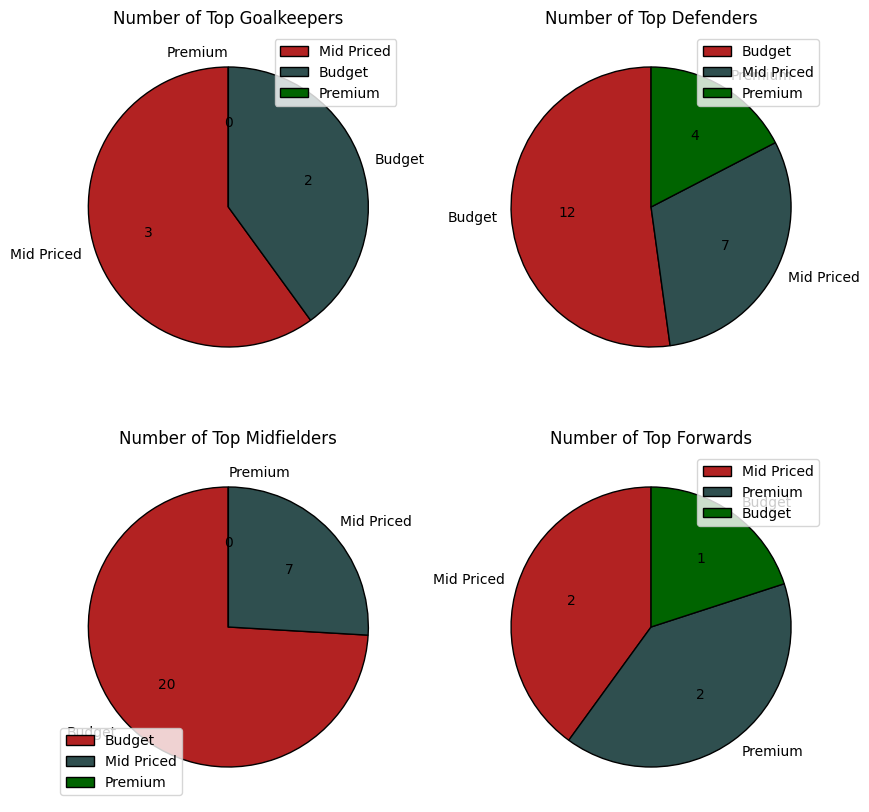

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
(ax1,ax2),(ax3,ax4) = ax


colors=['#B22222','#2F4F4F','#006400']
#Plot1
slices1 = top_df.groupby('Position')['price_range'].value_counts()['GKP']
labels1 = top_df.groupby('Position')['price_range'].value_counts()['GKP'].index
ax1.pie(slices1, labels=labels1, wedgeprops={'edgecolor':'black'}, colors=colors, startangle=90, autopct=make_autopct(slices1))
ax1.set(title='Number of Top Goalkeepers')
ax1.legend()

#Plot2
slices2 = top_df.groupby('Position')['price_range'].value_counts()['DEF']
labels2 = top_df.groupby('Position')['price_range'].value_counts()['DEF'].index
ax2.pie(slices2, labels=labels2, wedgeprops={'edgecolor':'black'}, colors=colors, startangle=90, autopct=make_autopct(slices2))
ax2.set(title='Number of Top Defenders')
ax2.legend()

#PLot3
slices3 = top_df.groupby('Position')['price_range'].value_counts()['MID']
labels3 = top_df.groupby('Position')['price_range'].value_counts()['MID'].index
ax3.pie(slices3, labels=labels3, wedgeprops={'edgecolor':'black'}, colors=colors, startangle=90, autopct=make_autopct(slices3))
ax3.set(title='Number of Top Midfielders')
ax3.legend()

#Plot4
slices4 = top_df.groupby('Position')['price_range'].value_counts()['FWD']
labels4 = top_df.groupby('Position')['price_range'].value_counts()['FWD'].index
ax4.pie(slices4, labels=labels4, wedgeprops={'edgecolor':'black'}, colors=colors, startangle=90, autopct=make_autopct(slices4))
ax4.set(title='Number of Top Forwards')
ax4.legend();

When a FPL Manager builds their squad, they have to spread their buget between premium players, mid-priced players and budget players. The composition of your squad has some influence on how many points you will get at the end of the season. A well-balanced team will always outperform a top-heavy team littered with buget fillers.

In the above plot we are interested in the composition of high performing players in each position. This will help in squad composition and will influence your formation.

1. The Defense is where you would have wanted to spend the most money on premium players (atleast 3) followed by the Midfield.
2. The Defense is also where you would have found the most variety in budget players
3. The Midfield would have been best composed with mid-price players and 1 or 2 premium players

Analysis By Player:

Now that we have a rough idea of where to look (club and position) for the high performing players, we can start analyzing the players to see what insights we can get from the data.

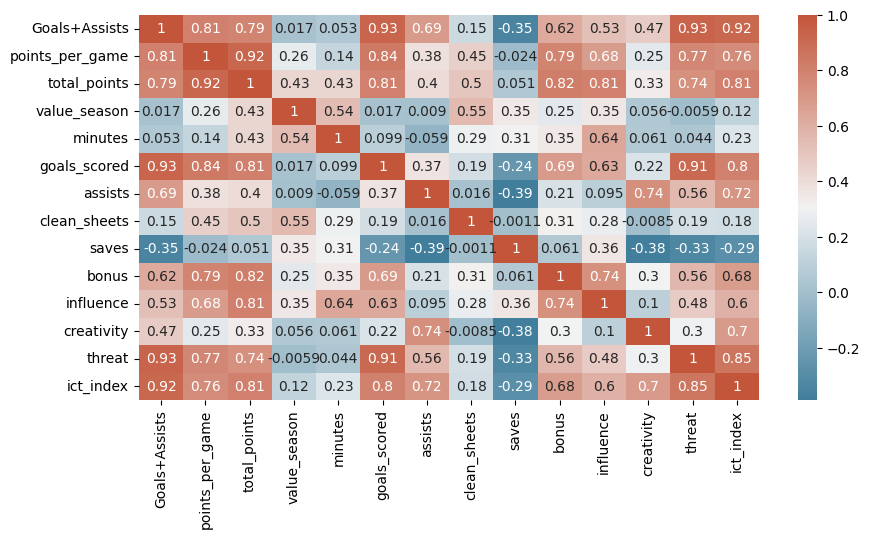

In [ ]:
top_df['Goals+Assists'] = top_df['goals_scored'] + top_df['assists']

 #Correlation between different variables
corr_df = top_df[['Goals+Assists', 'points_per_game',
        'total_points', 'value_season',
       'minutes', 'goals_scored', 'assists', 'clean_sheets',
      'saves', 'bonus', 'influence', 'creativity',
       'threat', 'ict_index'
       ]].corr()


f, ax = plt.subplots(figsize=(10,5))
#Configure custom diverging colormap
cmap = sns.diverging_palette(230,20, as_cmap=True)
#Draw map
sns.heatmap(corr_df, annot=True, cmap=cmap);

Here we are interested in the attributes that have dark shades of red or blue in the total points row as these have moderate to strong positive/negative correlation. We will consider all the features which have atleast 80% of correlation with total points

1. points_per_game
2. ict_index
2. influence
4. bonus
5. goals_scored

Since ict index is the mixture of influence, creativity and threat, and we are already considering influence, we dont have to consider ict_index again as from the above chat creativity and threat are not impacting much in the teams points

In [ ]:
top_df['roi_rank'] = (
    (top_df['points_per_game'] + top_df['influence'] + top_df['bonus'] + top_df['value_season'] + top_df['ict_index'] + top_df['goals_scored'])
                            .rank(method='dense', ascending=False)
                            .astype('float32')
)
top_df.sort_values('roi_rank', inplace = True)

In [ ]:
columns_required = ['Name', 'Team', 'Position', 'total_points', 'goals_scored', 'price', 'price_range', 'IsAvailable', 'points_range','roi_rank']
top_df = top_df[columns_required]

In [ ]:
top_df.groupby('Position')['total_points'].sum()

Position
DEF    2377
FWD     871
GKP     631
MID    3361
Name: total_points, dtype: int64

In [ ]:
top_df.groupby(['Position','points_range'])['points_range'].agg(Frequency='count')

Frequency
Position points_range           
DEF      <60                   0
         60-80                 2
         80-100               12
         100-120               5
         120-140               3
         140-160               0
         160-180               1
         180-200               0
         200+                  0
FWD      <60                   0
         60-80                 0
         80-100                0
         100-120               1
         120-140               0
         140-160               1
         160-180               1
         180-200               0
         200+                  2
GKP      <60                   0
         60-80                 0
         80-100                0
         100-120               2
         120-140               3
         140-160               0
         160-180               0
         180-200               0
         200+                  0
MID      <60                   0
         60-80                 0
         80-100                2
         100-120              16
         120-140               4
         140-160               1
         160-180               2
         180-200               2
         200+                  0

In [ ]:
Forwards = (
    top_df[(top_df['Position'] == 'FWD') &
           top_df['IsAvailable'] == True]
)

Forwards = Forwards[columns_required]

Goalkeepers = (
    top_df[(top_df['Position'] == 'GKP') &
           top_df['IsAvailable'] == True]
)

Goalkeepers = Goalkeepers[columns_required]

Midfielders = (
    top_df[(top_df['Position'] == 'MID') &
           top_df['IsAvailable'] == True]
)

Midfielders = Midfielders[columns_required]

Defenders = (
    top_df[(top_df['Position'] == 'DEF') &
           top_df['IsAvailable'] == True]
)

Defenders = Defenders[columns_required]

# Final Result

In [ ]:
len(Forwards),len(Goalkeepers), len(Midfielders), len(Defenders)

(5, 4, 26, 19)

In [ ]:
Goalkeepers

,Name,Team,Position,total_points,goals_scored,price,price_range,IsAvailable,points_range,roi_rank
29,David Raya Martin,Brentford,GKP,135,0,4.9,Budget,True,120-140,7.0
30,Bernd Leno,Fulham,GKP,113,0,4.6,Budget,True,100-120,9.0
32,José Malheiro de Sá,Wolves,GKP,131,0,5.0,Mid Priced,True,120-140,15.0
31,Nick Pope,Newcastle,GKP,134,0,5.4,Mid Priced,True,120-140,43.0


In [ ]:
Midfielders

,Name,Team,Position,total_points,goals_scored,price,price_range,IsAvailable,points_range,roi_rank
35,Bukayo Saka,Arsenal,MID,185,13,8.5,Mid Priced,True,180-200,3.0
36,Gabriel Martinelli Silva,Arsenal,MID,189,15,6.9,Mid Priced,True,180-200,5.0
34,Martin Ødegaard,Arsenal,MID,178,12,6.7,Mid Priced,True,160-180,6.0
53,Marcus Rashford,Man Utd,MID,174,15,7.1,Mid Priced,True,160-180,11.0
44,Solly March,Brighton,MID,139,6,5.2,Budget,True,120-140,12.0
58,James Ward-Prowse,Southampton,MID,113,7,6.3,Mid Priced,True,100-120,13.0
43,Pascal Groß,Brighton,MID,121,6,5.4,Budget,True,120-140,14.0
59,Pierre-Emile Højbjerg,Spurs,MID,112,4,5.4,Budget,True,100-120,16.0
52,Rodrigo Hernandez,Man City,MID,95,2,5.6,Budget,True,80-100,19.0
37,Leandro Trossard,Arsenal,MID,135,8,6.7,Mid Priced,True,120-140,20.0


In [ ]:
Defenders

,Name,Team,Position,total_points,goals_scored,price,price_range,IsAvailable,points_range,roi_rank
18,Kieran Trippier,Newcastle,DEF,173,1,6.2,Premium,True,160-180,8.0
1,Gabriel dos Santos Magalhães,Arsenal,DEF,129,3,5.3,Mid Priced,True,120-140,17.0
14,Trent Alexander-Arnold,Liverpool,DEF,115,1,7.5,Premium,True,100-120,21.0
22,Max Kilman,Wolves,DEF,96,0,4.3,Budget,True,80-100,22.0
11,Timothy Castagne,Leicester,DEF,102,2,4.3,Budget,True,100-120,27.0
6,Ben Mee,Brentford,DEF,114,3,5.1,Mid Priced,True,100-120,29.0
0,Benjamin White,Arsenal,DEF,139,2,5.0,Mid Priced,True,120-140,30.0
12,Virgil van Dijk,Liverpool,DEF,99,3,6.6,Premium,True,80-100,33.0
10,Tim Ream,Fulham,DEF,95,1,4.6,Budget,True,80-100,37.0
4,Tyrone Mings,Aston Villa,DEF,108,0,4.6,Budget,True,100-120,46.0


# Thank You...

# A Lot is yet to come......